In [ ]:
import mne
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mne.preprocessing import ICA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from mne.time_frequency import psd_array_multitaper
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score
import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import LinearAutoregressiveHMM


Extracting parameters from data/sub-02/eeg/sub-02_task-MOBAgame_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 6909399  =      0.000 ...  6909.399 secs...


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\amang\AppData\Local\Temp\ipykernel_30580\2396818097.py:9: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+', header=None, skiprows=1


Total events before filtering: 56
Total events after filtering: 44
Unique event IDs in filtered events: [13 14]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.5s


Not setting metadata
44 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 44 events and 3001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



C:\Users\amang\AppData\Local\Temp\ipykernel_30580\2396818097.py:49: RuntimeWarning: filter_length (3301) is longer than the signal (3001), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(1., 40., fir_design='firwin', verbose=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:   

Fitting ICA...
Fitting ICA to data using 66 channels (please be patient, this may take a while)


C:\Users\amang\AppData\Local\Temp\ipykernel_30580\2396818097.py:53: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 15 components
Fitting ICA took 2.4s.
ICA fitting complete.
Using EOG channel: FP1
Using EOG channel: FP2
ICA components to exclude: []
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 66 PCA components
ICA applied to the epochs.
Applying baseline correction (mode: mean)
Total epochs created: 44
Dropped epochs and reasons:
Event counts after epoching:
Kill: 16
Death: 28


C:\Users\amang\AppData\Local\Temp\ipykernel_30580\2396818097.py:66: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


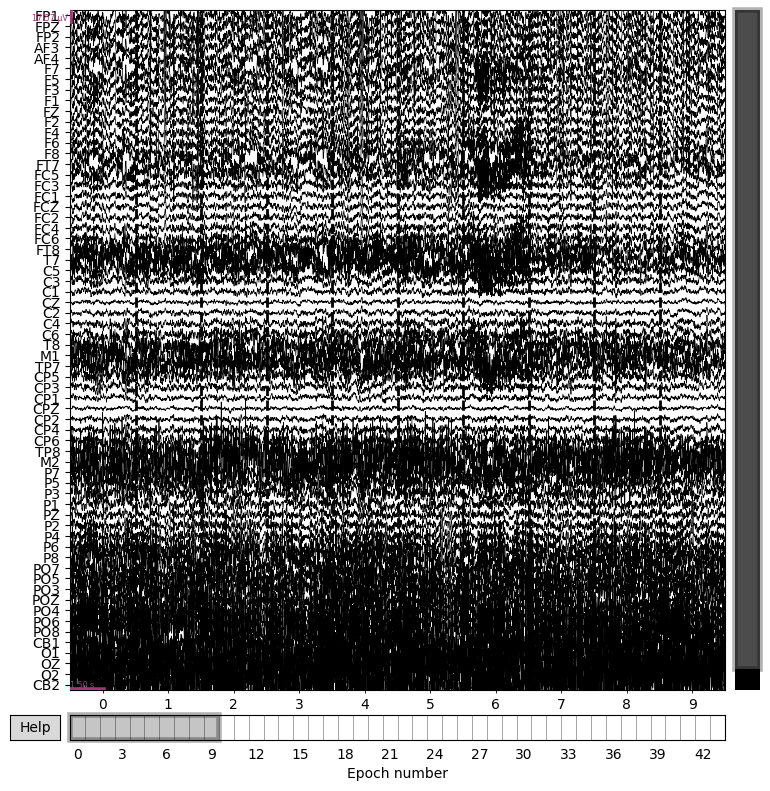

Overwriting existing file.
Overwriting existing file.
Epochs saved as 'subject2_kill_death_epochs-epo.fif'.


In [79]:
# Step 1: Load Raw Data and Events
raw = mne.io.read_raw_brainvision(
    'data/sub-02/eeg/sub-02_task-MOBAgame_eeg.vhdr',
    preload=True
)

events_df = pd.read_csv(
    'data/derivatives/markers/sub-02_task-MOBAgame_marker.txt',
    sep='\s+', header=None, skiprows=1
)
events_array = events_df.to_numpy().astype(int)
events_mne = np.column_stack((
    events_array[:, 0],
    np.zeros(len(events_array), dtype=int),
    events_array[:, 1]
)).astype(int)

# Step 2: Define Event IDs
event_id = {
    'Kill': 13,
    'Death': 14
}

# Step 3: Filter Events to Include Only 'Kill' and 'Death'
desired_event_ids = list(event_id.values())
filtered_events = events_mne[np.isin(events_mne[:, 2], desired_event_ids)]
print(f"Total events before filtering: {len(events_mne)}")
print(f"Total events after filtering: {len(filtered_events)}")
print("Unique event IDs in filtered events:", np.unique(filtered_events[:, 2]))

# Step 4: Create Epochs with Filtered Events
raw.notch_filter(freqs=np.arange(50, 251, 50), fir_design='firwin')
tmin, tmax = -1.0, 2.0
epochs = mne.Epochs(
    raw,
    filtered_events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    picks='eeg',
    preload=True,
    reject=None,
    flat=None,
    reject_by_annotation=False,
    verbose=True
)

# Step 5: Proceed with Preprocessing
epochs.filter(1., 40., fir_design='firwin', verbose=True)

ica = ICA(n_components=15, random_state=97, max_iter='auto')
print("Fitting ICA...")
ica.fit(epochs)
print("ICA fitting complete.")

eog_channels = ['FP1', 'FP2']
eog_inds = []

for ch in eog_channels:
    if ch in epochs.ch_names:
        inds, scores = ica.find_bads_eog(epochs, ch_name=ch)
        eog_inds.extend(inds)

ica.exclude = list(set(eog_inds))
print(f"ICA components to exclude: {ica.exclude}")
ica.apply(epochs)
print("ICA applied to the epochs.")

epochs.apply_baseline(baseline=(None, 0))

# Step 6: Validate and Inspect Epochs
print(f"Total epochs created: {len(epochs)}")

# Check for dropped epochs
if len(epochs.drop_log) > 0:
    print("Dropped epochs and reasons:")
    for idx, reason in enumerate(epochs.drop_log):
        if reason != ():
            print(f"Epoch {idx}: {reason}")
else:
    print("No epochs were dropped.")

# Check event counts
print("Event counts after epoching:")
for event_name, count in event_id.items():
    num_epochs = np.sum(epochs.events[:, 2] == count)
    print(f"{event_name}: {num_epochs}")

# Plot epochs
%matplotlib inline
epochs.plot(n_channels=64, scalings='auto', n_epochs=10)

# Step 7: Save the Preprocessed Epochs
epochs.save('subject2_kill_death_epochs-epo.fif', overwrite=True)
print("Epochs saved as 'subject2_kill_death_epochs-epo.fif'.")


In [80]:
data_duration = raw.times[-1]
print(f"Data duration: {data_duration/60:.2f} minutes")

Data duration: 115.16 minutes


In [ ]:
epochs = mne.read_epochs('subject2_kill_death_epochs-epo.fif', preload=True)

In [ ]:
# Assume 'epochs' is your preprocessed Epochs object with 'Kill' and 'Death' events
# Get data and labels
X = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
y = epochs.events[:, 2]  # Event IDs corresponding to 'Kill' and 'Death'

# Map event IDs to labels (e.g., 'Kill': 0, 'Death': 1)
event_id = {'Kill': 13, 'Death': 14}
label_map = {event_id['Kill']: 1, event_id['Death']: 0}
y = np.vectorize(label_map.get)(y)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)

In [ ]:
# Compute power spectral density (PSD)
sfreq = epochs.info['sfreq']
psds, freqs = psd_array_multitaper(
    X, sfreq=sfreq, fmin=1., fmax=40., verbose=False)

# Define frequency bands
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 40)
}

# Function to compute band power
def compute_band_power(psds, freqs, band):
    fmin, fmax = bands[band]
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    # Mean over frequency bands
    band_power = psds[:, :, freq_mask].mean(axis=2)
    return band_power

# Compute band power for all bands
band_powers = []
for band in bands:
    bp = compute_band_power(psds, freqs, band)
    bp = bp[:, :, np.newaxis]  # Expand dimensions to make it 3D
    band_powers.append(bp)

# Concatenate band powers to form the feature matrix
X_features = np.concatenate(band_powers, axis=2)
n_epochs, n_channels, n_bands = X_features.shape
X_features = X_features.reshape(n_epochs, n_channels * n_bands)
print("Feature matrix shape:", X_features.shape)


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.999)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA reduced training data shape:", X_train_pca.shape)
print("PCA reduced testing data shape:", X_test_pca.shape)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()



In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_pca)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
for label in np.unique(y_train):
    plt.scatter(
        X_train_tsne[y_train == label, 0],
        X_train_tsne[y_train == label, 1],
        label=f"{'Kill' if label == 0 else 'Death'}"
    )
plt.legend()
plt.title("t-SNE Visualization of Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [ ]:
# Train logistic regression model
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train_pca, y_train)

# Predict on test data
y_pred = clf.predict(X_test_pca)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Kill', 'Death']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Kill', 'Death'],
            yticklabels=['Kill', 'Death'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities
y_score = clf.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print("X_features shape:", X_features.shape)  # Should be (n_epochs, n_channels * n_bands)

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from sklearn.preprocessing import StandardScaler

# Assume 'X' is your preprocessed data: shape (n_epochs, n_channels, n_times)
# Ensure 'X' is defined in your workspace

# Convert data to JAX arrays
X_jax = jnp.array(X)  # Shape: (n_epochs, n_channels, n_times)

# Transpose to match expected shape (n_epochs, n_times, n_channels)
sequences = X_jax.transpose(0, 2, 1)  # Shape: (n_epochs, n_times, n_channels)

# Define model parameters
num_states = 2  # Number of hidden states (e.g., 'Kill' and 'Death')
emission_dim = sequences.shape[2]  # Number of features (channels)
num_lags = 1   # Autoregressive order

n_channels = emission_dim  # Define n_channels based on emission_dim

# Initialize the ARHMM
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)

# Flatten sequences into a single long sequence
concatenated_sequence = jnp.concatenate(sequences, axis=0)  # Shape: (n_epochs * n_times, n_channels)
sequence_lengths = [seq.shape[0] for seq in sequences]

# Check for NaNs or Infs in concatenated_sequence
if np.isnan(concatenated_sequence).any():
    raise ValueError("Data contains NaNs. Please clean the data.")
if np.isinf(concatenated_sequence).any():
    raise ValueError("Data contains Infs. Please clean the data.")

# Normalize the data to have zero mean and unit variance
scaler = StandardScaler()
concatenated_sequence = scaler.fit_transform(np.array(concatenated_sequence))  # Convert to NumPy array for scaler
concatenated_sequence = concatenated_sequence.astype(np.float32)  # Convert back to float32 for JAX

# Convert back to JAX array after normalization
concatenated_sequence = jnp.array(concatenated_sequence)

# Define initial state probabilities to avoid Dirichlet sampling
initial_probs = jnp.ones(num_states) / num_states  # Uniform initial probabilities

# Initialize parameters with specified initial_probs
params, props = arhmm.initialize(
    key=jr.PRNGKey(0),
    method='kmeans',
    initial_probs=initial_probs,
    emissions=concatenated_sequence  # Shape: (n_epochs * n_times, n_channels)
)

print("Concatenated Sequence Shape:", concatenated_sequence.shape)  # Expected: (n_epochs * n_times, n_channels)

# Compute inputs before fitting
inputs = arhmm.compute_inputs(concatenated_sequence)  # Shape depends on num_lags

# Fit the model with emissions and inputs
fitted_params, lps = arhmm.fit_em(
    params,
    props,
    emissions=concatenated_sequence,
    inputs=inputs,
    num_iters=50,
    verbose=True
)

# Run the smoother
posterior = arhmm.smoother(fitted_params, concatenated_sequence, inputs=inputs)

# Extract smoothed states
smoothed_states = posterior.smoothed_probs.argmax(axis=1)

# Split smoothed states back into epochs
split_indices = np.cumsum(sequence_lengths[:-1])
smoothed_states_epochs = np.split(smoothed_states, split_indices)

# (Optional) Print or analyze the smoothed states
print("Smoothed States per Epoch:", smoothed_states_epochs)


In [ ]:
from scipy.stats import mode
import numpy as np
from sklearn.metrics import classification_report

# Assuming `smoothed_states_epochs` is your input list of arrays
y_pred_arhmm = []

# Calculate the mode for each epoch
for states in smoothed_states_epochs:
    most_common_state = mode(np.array(states), keepdims=True).mode[0]  # Ensure .mode is iterable
    y_pred_arhmm.append(most_common_state)

y_pred_arhmm = np.array(y_pred_arhmm)

# Map hidden states to labels
state_to_label = {0: 0, 1: 1}  # Define the mapping

# Use a default value in case of missing keys
y_pred_labels = np.vectorize(lambda x: state_to_label.get(x, -1))(y_pred_arhmm)  # Default -1 for unmapped states

# Evaluate the model (replace `y` with your actual labels)
print("ARHMM Classification Report:")
print(classification_report(y, y_pred_labels, target_names=['Kill', 'Death']))



In [ ]:
# Assuming `y` is your true labels array of shape (n_epochs,)
# Map the labels to match the epochs
n_times=3001
true_labels = np.repeat(y, n_times)  # n_times is the number of time points per epoch

# Since you have `smoothed_states` which is the predicted state for each time point,
# and you have split them into epochs (`smoothed_states_epochs`), we can concatenate them back
predicted_states = np.concatenate(smoothed_states_epochs)

# Ensure that the lengths match
print("Length of true labels:", len(true_labels))
print("Length of predicted states:", len(predicted_states))
# Create a time axis
time = np.arange(len(predicted_states))
# Map 'Kill' and 'Death' labels to 0 and 1
label_map = {0: 'Kill', 1: 'Death'}  # Adjust based on your label encoding

# Create arrays for plotting
true_labels_numeric = np.repeat(y, n_times)  # Assuming y uses 0 for 'Kill' and 1 for 'Death'

plt.figure(figsize=(15, 5))

# Plot predicted states
plt.plot(time, predicted_states, label='Predicted States', alpha=0.7)

# Plot true labels
plt.plot(time, true_labels_numeric, label='True Labels', alpha=0.7)

# Adding markers at epoch boundaries (optional)
epoch_boundaries = np.cumsum([0] + sequence_lengths)
for boundary in epoch_boundaries:
    plt.axvline(x=boundary, color='grey', linestyle='--', alpha=0.5)

plt.title('Actual Labels vs. Predicted States from ARHMM')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

start_time = 0        # Starting index
end_time = n_times * 5  # For example, the first 5 epochs

plt.figure(figsize=(15, 5))
plt.plot(time[start_time:end_time], predicted_states[start_time:end_time], label='Predicted States', alpha=0.7)
plt.plot(time[start_time:end_time], true_labels_numeric[start_time:end_time], label='True Labels', alpha=0.7)

plt.title('Actual Labels vs. Predicted States from ARHMM (First 5 Epochs)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot the hidden states for the first epoch
plt.figure(figsize=(10, 2))
plt.plot(smoothed_states_epochs[0], drawstyle='steps-mid')
plt.title('Inferred Hidden States for Epoch 0')
plt.xlabel('Time')
plt.ylabel('Hidden State')
plt.show()


In [ ]:
# Calculate state occupancy
state_counts = np.bincount(smoothed_states, minlength=num_states)
state_proportions = state_counts / len(smoothed_states)

# Plot state occupancy
plt.figure(figsize=(6, 4))
plt.bar(range(num_states), state_proportions, tick_label=[f'State {i}' for i in range(num_states)])
plt.title('ARHMM State Occupancy Proportions')
plt.xlabel('State')
plt.ylabel('Proportion of Time')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

train_losses = []  # Store training losses per epoch
val_losses = []    # Store validation losses per epoch

# Training loop
n_epochs_cnn = 100
for epoch in range(n_epochs_cnn):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)
    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Print losses for the current epoch
    print(f"Epoch {epoch+1}/{n_epochs_cnn}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# Evaluate on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs_cnn + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs_cnn + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# Assume 'X_features' is your extracted band power features: shape (n_epochs, n_features)
# 'y' is the array of labels (Kill=0, Death=1) of shape (n_epochs,)

# Standardize the features
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

# Prepare the data for the ARHMM without PCA
# Reshape to create sequences (n_epochs, 1, n_features)
sequences = X_features_scaled[:, np.newaxis, :]  # Shape: (n_epochs, 1, n_features)

# Concatenate sequences to create a single long sequence
concatenated_sequence = jnp.concatenate(sequences, axis=0)  # Shape: (n_epochs, n_features)
sequence_lengths = [seq.shape[0] for seq in sequences]  # All ones

# Initialize the ARHMM
num_states = 2  # Number of hidden states
emission_dim = concatenated_sequence.shape[1]  # n_features
num_lags = 2   # Autoregressive order

arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)

# Define initial state probabilities
initial_probs = jnp.ones(num_states) / num_states  # Uniform initial probabilities

# Initialize parameters
params, props = arhmm.initialize(
    key=jr.PRNGKey(0),
    method='kmeans',
    initial_probs=initial_probs,
    emissions=concatenated_sequence
)

# Compute inputs
inputs = arhmm.compute_inputs(concatenated_sequence)

# Fit the ARHMM model
fitted_params, lps = arhmm.fit_em(
    params,
    props,
    emissions=concatenated_sequence,
    inputs=inputs,
    num_iters=50,
    verbose=True
)

# Run the smoother
posterior = arhmm.smoother(fitted_params, concatenated_sequence, inputs=inputs)

# Extract the most probable states
smoothed_states = np.array(posterior.smoothed_probs.argmax(axis=1))

# Evaluate the model
y_pred_arhmm = smoothed_states
y_true = y  # Actual labels

print("ARHMM Classification Report (Without PCA):")
print(classification_report(y_true, y_pred_arhmm, target_names=['Kill', 'Death']))

# Now, apply PCA to the features
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_features_pca = pca.fit_transform(X_features_scaled)

# Prepare sequences with PCA-reduced features
sequences_pca = X_features_pca[:, np.newaxis, :]  # Shape: (n_epochs, 1, n_components)

# Concatenate sequences
concatenated_sequence_pca = jnp.concatenate(sequences_pca, axis=0)  # Shape: (n_epochs, n_components)

emission_dim_pca = concatenated_sequence_pca.shape[1]

# Initialize the ARHMM with PCA-reduced features
arhmm_pca = LinearAutoregressiveHMM(num_states, emission_dim_pca, num_lags=num_lags)

# Initialize parameters
params_pca, props_pca = arhmm_pca.initialize(
    key=jr.PRNGKey(0),
    method='kmeans',
    initial_probs=initial_probs,
    emissions=concatenated_sequence_pca
)

# Compute inputs
inputs_pca = arhmm_pca.compute_inputs(concatenated_sequence_pca)

# Fit the ARHMM model
fitted_params_pca, lps_pca = arhmm_pca.fit_em(
    params_pca,
    props_pca,
    emissions=concatenated_sequence_pca,
    inputs=inputs_pca,
    num_iters=50,
    verbose=True
)

# Run the smoother
posterior_pca = arhmm_pca.smoother(fitted_params_pca, concatenated_sequence_pca, inputs=inputs_pca)

# Extract the most probable states
smoothed_states_pca = np.array(posterior_pca.smoothed_probs.argmax(axis=1))

# Evaluate the model
y_pred_arhmm_pca = smoothed_states_pca

print("ARHMM Classification Report (With PCA):")
print(classification_report(y_true, y_pred_arhmm_pca, target_names=['Kill', 'Death']))
